In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
import os
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
base_dir = "/media/Data/VBS/VBS_Evaluation/vbse2022/"
dfs = []
for f in os.listdir(base_dir):
    df = pd.read_pickle(f"{base_dir}/{f}")
    dfs.append(df)

dataset = pd.concat(dfs)

## Preprocessing

In [3]:
dataset = dataset.loc[dataset["type"]!="submission"]
dataset = dataset.loc[dataset["category"]!="SUBMIT"]
dataset = dataset.loc[~((dataset["team"]=="CVHunter")&(dataset["category"]=="BROWSING"))]
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace("Temporal CLIP: ","")
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace("CLIP: ","")
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace(">","")
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace(":","")
dataset = dataset.loc[dataset["category"]!="BROWSING"]
dataset = dataset.loc[dataset["category"]!="Browsing"]
dataset = dataset.loc[dataset["elapsed_since_task_start_ms"]>=0]

In [4]:
dataset.shape

(4361, 16)

In [5]:
dataset["System"] = "None"
dataset.loc[dataset["team"].str.contains("visione"),"System"] = "visione"
dataset.loc[dataset["team"].str.contains("vibro"),"System"] = "vibro"
dataset.loc[dataset["team"].str.contains("cvhunter"),"System"] = "cvhunter"

In [6]:
# merge visione temporal querries
visioneTemporal = dataset.loc[((dataset["System"]=="visione")&(dataset["additionals"].str.contains('"queryparameter":"Temporal_')))]
prev_timestamp = 0
newRows = []
visioneNonDuplicate = visioneTemporal.drop_duplicates(subset=["task","team","timestamp"])


txtGroupby = visioneTemporal.groupby(["task","team","timestamp"]).agg({'value': ' '.join}).reset_index()    

for (idx, row) in txtGroupby.iterrows():    
    visioneNonDuplicate.loc[((visioneNonDuplicate.user==row["team"])&(visioneNonDuplicate.timestamp==row["timestamp"])),"value"] = row["value"]
dataset = dataset.loc[~((dataset["System"]=="visione")&(dataset["additionals"].str.contains('"queryparameter":"Temporal_')))]
dataset = pd.concat([dataset,visioneNonDuplicate])
dataset.shape

/home/administrator/anaconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(3698, 17)

In [7]:
dataset["QT"] = "None"

#### Data will be grouped as follows


1. Text: jointEmbedding and concept search
2. ODLS: Objectbased- Detection, Localisation and Segmentation
3. Color: Low Level Features and Color Search
4. OCR
5. Image: Image-based Searches 

In [8]:
# Text
dataset.loc[dataset["type"].str.contains("jointEmbedding"),"QT"] = "Text"
dataset.loc[dataset["type"].str.contains("JointEmbedding"),"QT"] = "Text"
dataset.loc[dataset["type"].str.contains("concept"),"QT"] = "Text"
dataset.loc[dataset["value"].str.contains("jointEmbedding"),"QT"] = "Text"

In [9]:
# ODLS
dataset.loc[dataset["type"].str.contains("LocalizedObjectAndColors"),"QT"] = "ODLS"
dataset.loc[dataset["type"].str.contains("semanticSegmentation"),"QT"] = "ODLS"
dataset.loc[dataset["type"].str.contains("numberOfObjects"),"QT"] = "ODLS"

In [10]:
#dataset.loc[dataset["value"].str.contains("color")]

In [11]:
# Sketch
dataset.loc[dataset["value"] == "color" ,"QT"] = "Color"
dataset.loc[dataset["type"].str.contains("dominantColor"),"QT"] = "Color"

In [12]:
# IMAGE
dataset.loc[dataset["category"].str.contains("IMAGE"),"QT"] = "IMAGE"
dataset.loc[dataset["category"].str.contains("Image"),"QT"] = "IMAGE"

In [13]:
# temporal queries
dataset.loc[dataset["category"].str.contains("TEMPORAL"),"QT"] = "TEMPORAL"
dataset.loc[dataset["value"].str.contains(" > "),"QT"] = "TEMPORAL"
dataset.loc[dataset["additionals"].str.contains("Temporal_query"),"QT"] = "TEMPORAL"

In [14]:
dataset = dataset.reset_index().groupby('value').apply(lambda x: x[~(x.duplicated(subset=['value', 'team']) & (x['elapsed_since_task_start_ms'].diff() < 1000))]).reset_index(drop=True)

dataset.shape

(3251, 19)

In [15]:
dataset = dataset.reset_index().groupby('value').apply(lambda x: x[~(x.duplicated(subset=['value', 'team', 'additionals', 'task']))]).reset_index(drop=True)

dataset.shape

(2362, 20)

# Querytype analysis

In [17]:
dataset.groupby(["team", "QT"])[["value"]].count()

value
team      QT             
cvhunter1 IMAGE        25
          TEMPORAL     13
          Text        224
cvhunter2 IMAGE        96
          TEMPORAL     22
          Text         93
cvhunter3 IMAGE        75
          TEMPORAL     21
          Text         95
cvhunter4 IMAGE        51
          TEMPORAL     24
          Text         86
vibro1    Color         1
          IMAGE       112
          Text        120
vibro2    Color         1
          IMAGE        95
          TEMPORAL     36
          Text         75
vibro3    IMAGE        69
          TEMPORAL     60
          Text        129
vibro4    IMAGE        28
          Text        113
visione1  IMAGE        22
          ODLS          3
          TEMPORAL     64
          Text        101
visione2  IMAGE         3
          ODLS         39
          TEMPORAL     27
          Text        111
visione3  IMAGE         4
          ODLS          4
          TEMPORAL     40
          Text         77
visione4  IMAGE         8
          ODLS         46
          TEMPORAL     44
          Text        105

In [19]:
dataset.groupby(["System", "QT"])[["value"]].count()

value
System   QT             
cvhunter IMAGE       247
         TEMPORAL     80
         Text        498
vibro    Color         2
         IMAGE       304
         TEMPORAL     96
         Text        437
visione  IMAGE        37
         ODLS         92
         TEMPORAL    175
         Text        394

In [20]:
dataset.groupby(["System", "QT"])[["value"]].count()

value
System   QT             
cvhunter IMAGE       247
         TEMPORAL     80
         Text        498
vibro    Color         2
         IMAGE       304
         TEMPORAL     96
         Text        437
visione  IMAGE        37
         ODLS         92
         TEMPORAL    175
         Text        394

In [21]:
dataset.groupby(["System","team", "QT"])[["value"]].count()

value
System   team      QT             
cvhunter cvhunter1 IMAGE        25
                   TEMPORAL     13
                   Text        224
         cvhunter2 IMAGE        96
                   TEMPORAL     22
                   Text         93
         cvhunter3 IMAGE        75
                   TEMPORAL     21
                   Text         95
         cvhunter4 IMAGE        51
                   TEMPORAL     24
                   Text         86
vibro    vibro1    Color         1
                   IMAGE       112
                   Text        120
         vibro2    Color         1
                   IMAGE        95
                   TEMPORAL     36
                   Text         75
         vibro3    IMAGE        69
                   TEMPORAL     60
                   Text        129
         vibro4    IMAGE        28
                   Text        113
visione  visione1  IMAGE        22
                   ODLS          3
                   TEMPORAL     64
                   Text        101
         visione2  IMAGE         3
                   ODLS         39
                   TEMPORAL     27
                   Text        111
         visione3  IMAGE         4
                   ODLS          4
                   TEMPORAL     40
                   Text         77
         visione4  IMAGE         8
                   ODLS         46
                   TEMPORAL     44
                   Text        105

In [22]:
dataset.groupby(["System","team", "QT"])[["value"]].count()

value
System   team      QT             
cvhunter cvhunter1 IMAGE        25
                   TEMPORAL     13
                   Text        224
         cvhunter2 IMAGE        96
                   TEMPORAL     22
                   Text         93
         cvhunter3 IMAGE        75
                   TEMPORAL     21
                   Text         95
         cvhunter4 IMAGE        51
                   TEMPORAL     24
                   Text         86
vibro    vibro1    Color         1
                   IMAGE       112
                   Text        120
         vibro2    Color         1
                   IMAGE        95
                   TEMPORAL     36
                   Text         75
         vibro3    IMAGE        69
                   TEMPORAL     60
                   Text        129
         vibro4    IMAGE        28
                   Text        113
visione  visione1  IMAGE        22
                   ODLS          3
                   TEMPORAL     64
                   Text        101
         visione2  IMAGE         3
                   ODLS         39
                   TEMPORAL     27
                   Text        111
         visione3  IMAGE         4
                   ODLS          4
                   TEMPORAL     40
                   Text         77
         visione4  IMAGE         8
                   ODLS         46
                   TEMPORAL     44
                   Text        105

In [23]:
ds = dataset.replace(np.inf, 20000)
ds[ds["rank_video"] < 20000].groupby(["System","team", "type"])[["rank_video"]].max()

rank_video
System   team      type                                 
cvhunter cvhunter1 JointEmbedding                 9907.0
                   feedbackModel                  3704.0
         cvhunter2 JointEmbedding                 8769.0
                   feedbackModel                  5837.0
         cvhunter3 JointEmbedding                 8459.0
                   feedbackModel                  6720.0
         cvhunter4 JointEmbedding                 8459.0
                   feedbackModel                  8254.0
vibro    vibro1    color                           120.0
                   globalFeatures                 9820.0
                   jointEmbedding                 8718.0
         vibro2    color                          3857.0
                   frame > frame                   159.0
                   frame > text                   2503.0
                   globalFeatures                 9707.0
                   jointEmbedding                 9617.0
                   text > frame                   2777.0
                   text > text                    3852.0
         vibro3    frame > frame                    55.0
                   frame > text                   7892.0
                   globalFeatures                 6640.0
                   jointEmbedding                 9785.0
                   text > frame                   4276.0
                   text > text                    9357.0
         vibro4    globalFeatures                 6960.0
                   jointEmbedding                 9463.0
visione  visione1   LocalizedObjectAndColors        39.0
                   LocalizedObjectAndColors       4001.0
                   globalFeatures                  719.0
                   jointEmbedding                 8872.0
         visione2   LocalizedObjectAndColors      9017.0
                   LocalizedObjectAndColors       9017.0
                   globalFeatures                 1282.0
                   jointEmbedding                 9007.0
         visione3   LocalizedObjectAndColors      5065.0
                   LocalizedObjectAndColors       4178.0
                   globalFeatures                 1295.0
                   jointEmbedding                 8525.0
         visione4   LocalizedObjectAndColors      9343.0
                   LocalizedObjectAndColors       9343.0
                   globalFeatures                 6901.0
                   jointEmbedding                 9635.0

# Some Plots

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

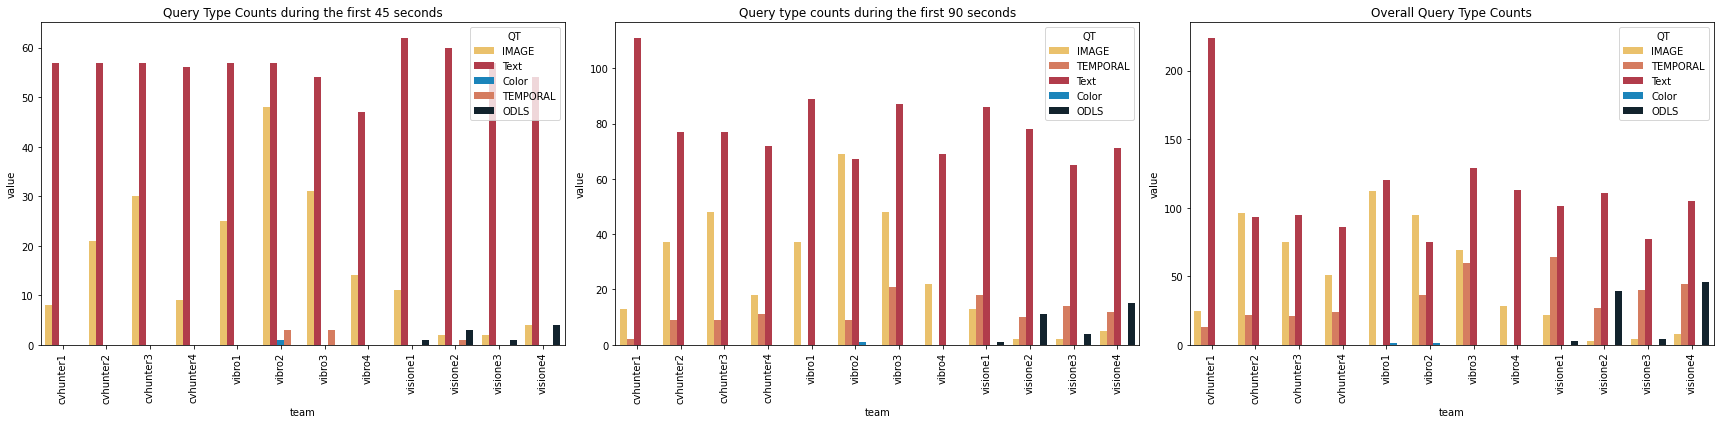

In [25]:
# Group data by team and QT for the first plot
grouped_1 = dataset[(dataset["elapsed_since_task_start_ms"] < 45*1000)].groupby(["team", "QT"])[["value"]].count()
grouped_1 = grouped_1.reset_index()

# Group data by team and QT for the second plot
grouped_2 = dataset[(dataset["elapsed_since_task_start_ms"] < 90*1000)].groupby(["team", "QT"])[["value"]].count()
grouped_2 = grouped_2.reset_index()

# Group data by team and QT for the third plot
grouped_3 = dataset.groupby(["team", "QT"])[["value"]].count()
grouped_3 = grouped_3.reset_index()

# Define the color palette
palette = {
    "IMAGE": "#FFC857",
    "TEMPORAL": "#E9724C",
    "Text": "#C5283D",
    "Color": "#008DD5",
    "ODLS": "#0E2431"
}

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# Plot the first subplot
sns.barplot(x='team', y='value', hue='QT', data=grouped_1, palette=palette, ax=axs[0])
axs[0].set_title("Query Type Counts during the first 45 seconds")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

# Plot the second subplot
sns.barplot(x='team', y='value', hue='QT', data=grouped_2, palette=palette, ax=axs[1])
axs[1].set_title("Query type counts during the first 90 seconds")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

# Plot the third subplot
sns.barplot(x='team', y='value', hue='QT', data=grouped_3, palette=palette, ax=axs[2])
axs[2].set_title("Overall Query Type Counts")
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)

# Adjust layout and display the plot
fig.tight_layout()
plt.show()


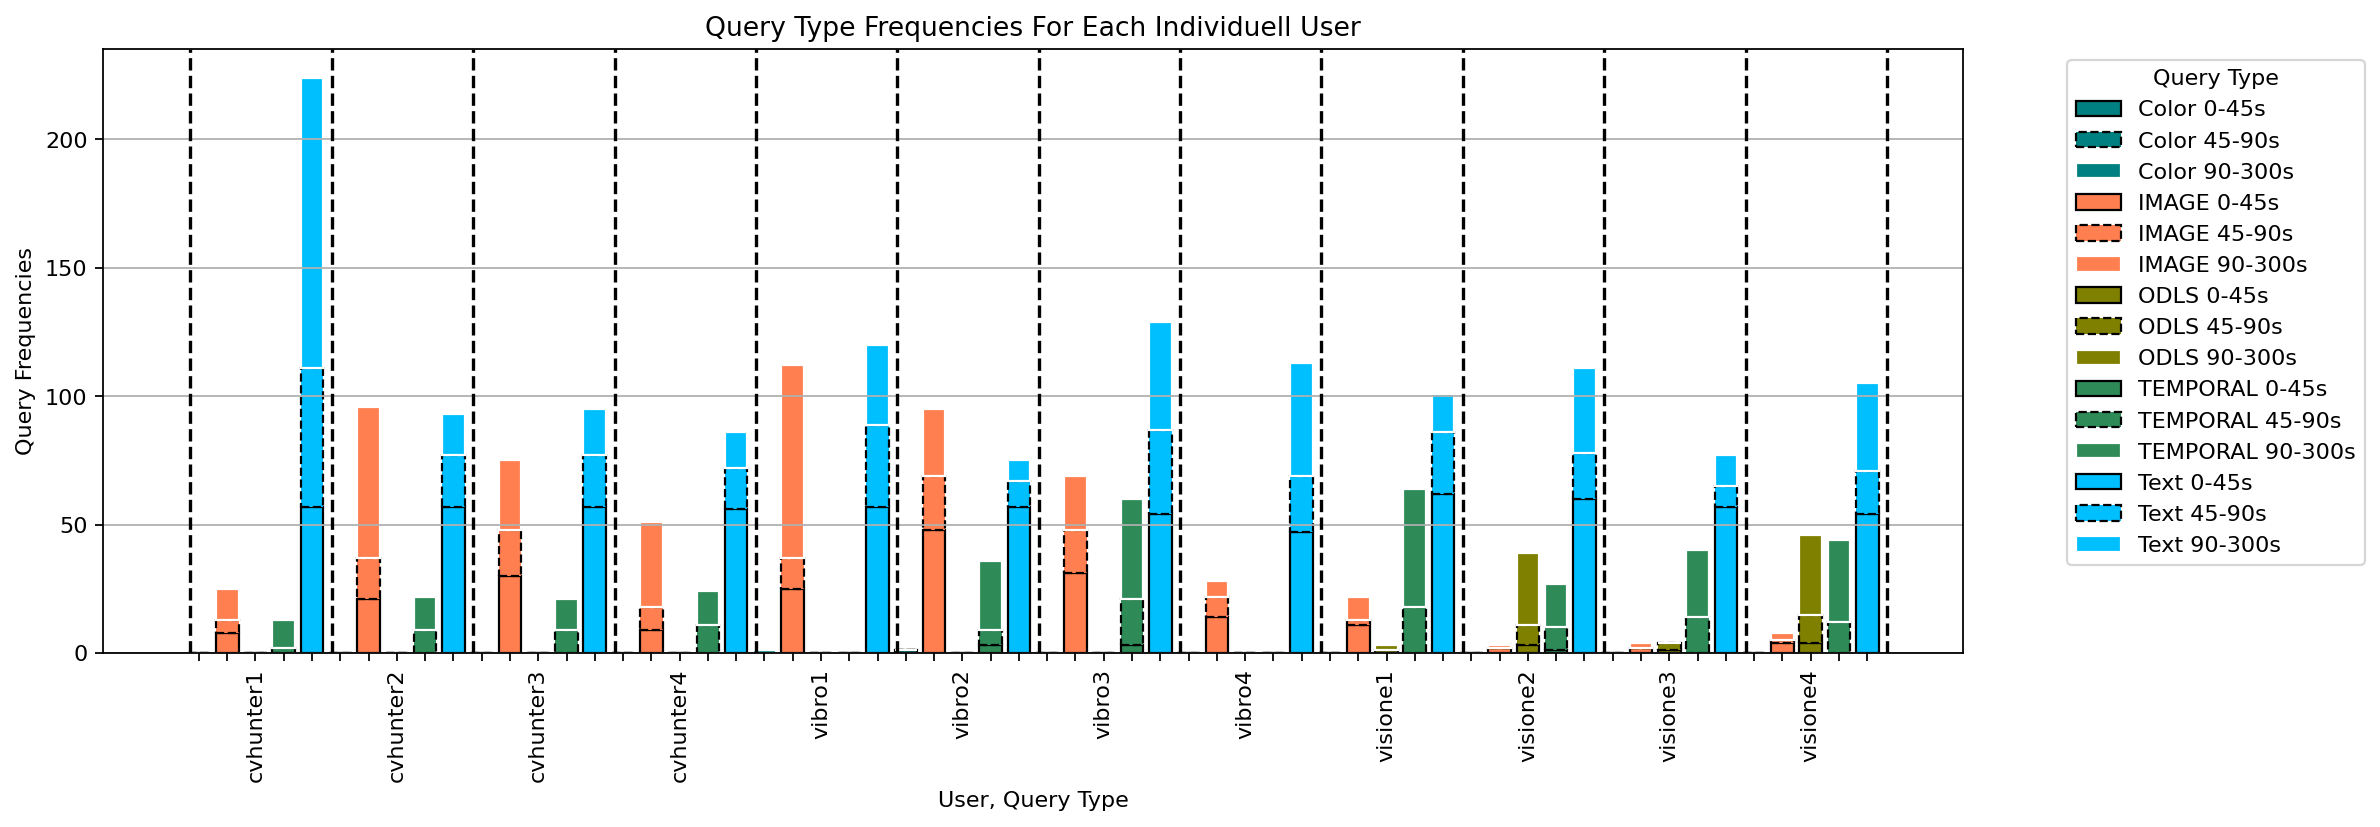

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Group data by team, QT and time period
grouped = dataset.groupby(["team", "QT", pd.cut(dataset["elapsed_since_task_start_ms"], [0, 45*1000, 90*1000, 5*60*1000])])[["value"]].count()

grouped = grouped.reset_index()

# Reset the index of grouped
#grouped = grouped.set_index(['QT', 'team', 'elapsed_since_task_start_ms'])

# Pivot the dataframe
pivot_table = pd.pivot_table(grouped, values='value', index=['QT', 'team'], columns='elapsed_since_task_start_ms', aggfunc='sum')
pivot_table = pivot_table.sort_values(by=["team", "QT"])

palette = {
    "IMAGE": "coral",
    "TEMPORAL": "seagreen",
    "Text": "deepskyblue",
    "Color": "teal",
    "ODLS": "olive"
}

# Define the figure size and dpi
fig = plt.figure(figsize=(15, 5), dpi=160)

team_counter = 0
prev_team = None

# Iterate over each team and QT
for i, (index, row) in enumerate(pivot_table.iterrows()):
    # Get the team and QT
    qt, team = index
    #if team == "vibro2":
        # Get the data for the current team and QT
    data = row.values
        #print(index, data)
    if i < 5:
        # Plot the stacked bar chart
        plt.bar(x=i, height=data[0], color=palette[qt], edgecolor="black", label=f"{qt} 0-45s")
        plt.bar(x=i, height=data[1], bottom=data[0], color=palette[qt], edgecolor="black", linestyle="--", label=f"{qt} 45-90s")
        plt.bar(x=i, height=data[2], bottom=data[0]+data[1], color=palette[qt], edgecolor="white", label=f"{qt} 90-300s")

    else:
        plt.bar(x=i, height=data[0], color=palette[qt], edgecolor="black")
        plt.bar(x=i, height=data[1], bottom=data[0], color=palette[qt], edgecolor="black", linestyle="--")
        plt.bar(x=i, height=data[2], bottom=data[0]+data[1], color=palette[qt], edgecolor="white")
        
    if team != pivot_table.index[i-1][1]:
        plt.axvline(x=i-0.3, color='black', linestyle='--')
        
plt.axvline(x=i+0.7, color='black', linestyle='--')
# Set the x-ticks and labels
plt.xticks(range(len(pivot_table)), [f"{team}" if (((i+3)%5 == 0)) else "" for i, (qt, team) in enumerate(pivot_table.index)], rotation=90)

# Set the x and y labels, title and legend
plt.xlabel("User, Query Type")
plt.ylabel("Query Frequencies")
plt.title("Query Type Frequencies For Each Individuell User")
plt.legend( title="Query Type", bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.yscale("log")
# Show the plot
plt.grid(axis="y")
plt.show()
fig.savefig('./plots/qt_frequencies.pdf', dpi=200, pad_inches=0.1, bbox_inches='tight')

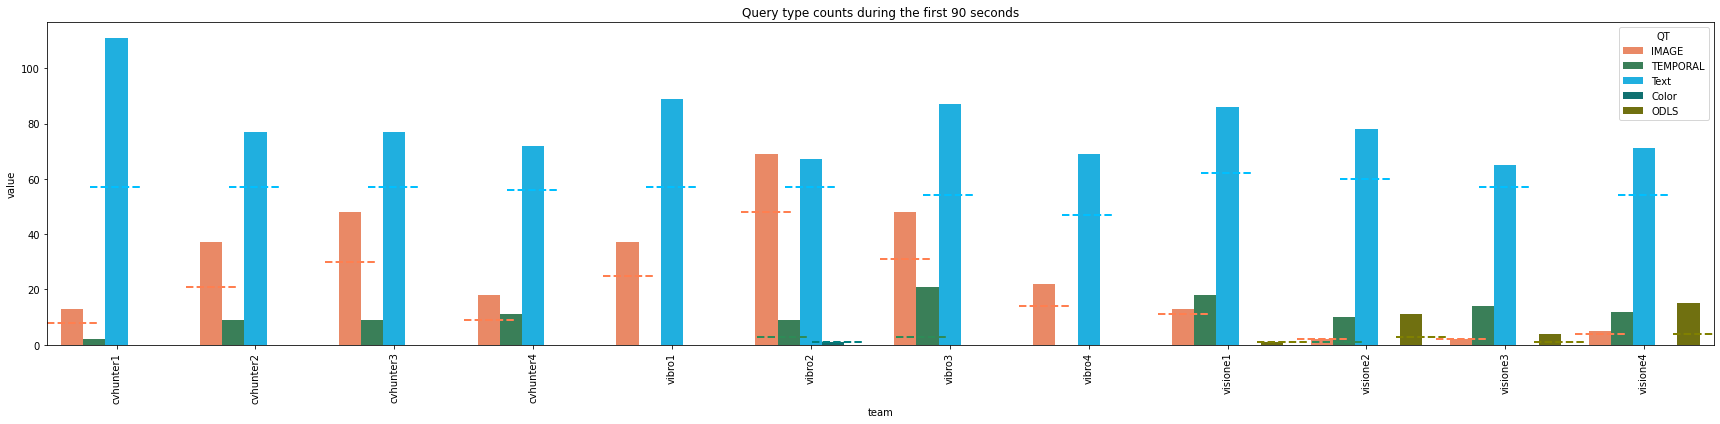

In [32]:
# create the first plot
grouped_45s = dataset[(dataset["elapsed_since_task_start_ms"] < 45*1000)].groupby(["team", "QT"])[["value"]].count()
grouped_45s = grouped_45s.reset_index()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(24,6), sharey=True)

# # plot the results using seaborn
# sns.barplot(x='team', y='value', hue='QT', data=grouped_45s, palette=palette, ax=axs[0])
# axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
# axs[0].set_title("Query Type Counts during the first 45 seconds")

# create the second plot
grouped_90s = dataset[(dataset["elapsed_since_task_start_ms"] < 90*1000)].groupby(["team", "QT"])[["value"]].count()
grouped_90s = grouped_90s.reset_index()

# plot the results using seaborn
ax2 = sns.barplot(x='team', y='value', hue='QT', data=grouped_90s, palette=palette, ax=axs)
bar_x = [rect.get_x() for rect in ax2.patches]
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
axs.set_title("Query type counts during the first 90 seconds")

# add horizontal lines to indicate values from the first plot
for i, team in enumerate(grouped_90s["team"].unique()):
    for j, qt in enumerate(grouped_90s["QT"].unique()):
        value_45s = grouped_45s[(grouped_45s["team"] == team) & (grouped_45s["QT"] == qt)]["value"].values
        pos = i*5+j
        #print(team, qt, i, j, pos, len(value_45s))
        if len(value_45s) > 0:
            
#             try:
#                 xmin = 0#1-1/pos
#             except:
#                 xmin=0
                
#             xmax = 0.1#1-1/(pos+1)
            
            offset = 0 if j == 0 else 0.0075
            xmin = (pos)/len(bar_x) - offset
            xmax = xmin+0.03
            
        
            axs.axhline(linestyle='--',y=value_45s, color=palette[qt], linewidth=2, xmin=xmin, xmax=xmax)
           
            
            #break

# adjust layout and show the plot
plt.tight_layout()
plt.show()


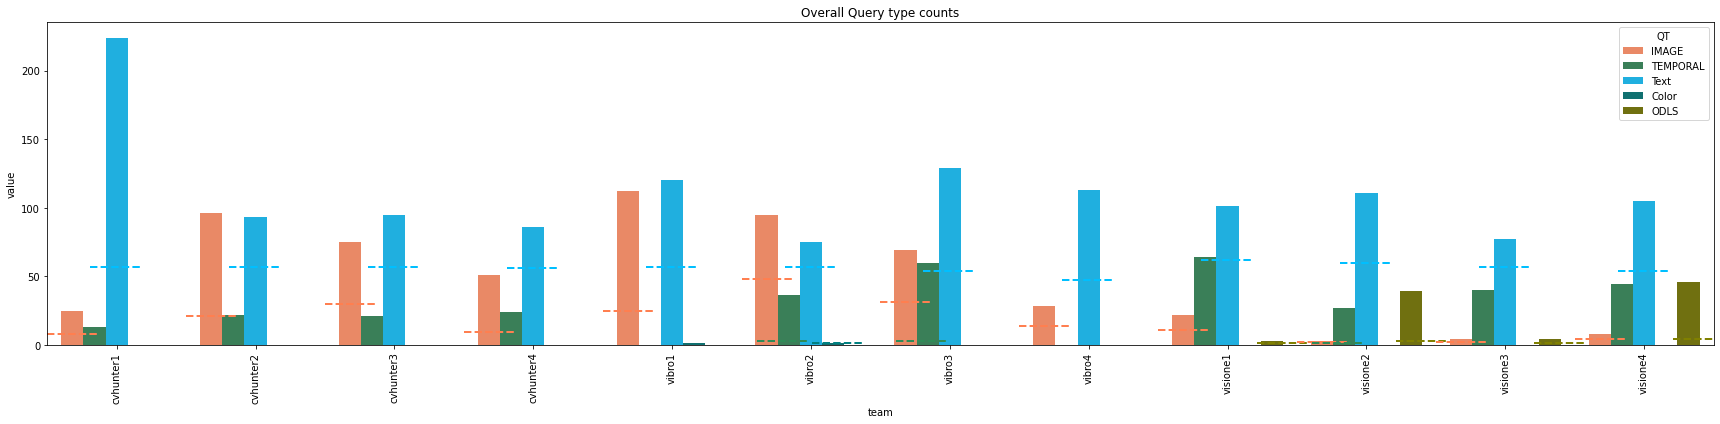

In [33]:
# create the first plot
grouped_45s = dataset[(dataset["elapsed_since_task_start_ms"] < 45*1000)].groupby(["team", "QT"])[["value"]].count()
grouped_45s = grouped_45s.reset_index()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(24,6), sharey=True)

# # plot the results using seaborn
# sns.barplot(x='team', y='value', hue='QT', data=grouped_45s, palette=palette, ax=axs[0])
# axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
# axs[0].set_title("Query Type Counts during the first 45 seconds")

# create the second plot
grouped_90s = dataset.groupby(["team", "QT"])[["value"]].count()
grouped_90s = grouped_90s.reset_index()

# plot the results using seaborn
ax2 = sns.barplot(x='team', y='value', hue='QT', data=grouped_90s, palette=palette, ax=axs)
bar_x = [rect.get_x() for rect in ax2.patches]
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
axs.set_title("Overall Query type counts")

# add horizontal lines to indicate values from the first plot
for i, team in enumerate(grouped_90s["team"].unique()):
    for j, qt in enumerate(grouped_90s["QT"].unique()):
        value_45s = grouped_45s[(grouped_45s["team"] == team) & (grouped_45s["QT"] == qt)]["value"].values
        pos = i*5+j
        #print(team, qt, i, j, pos, len(value_45s))
        if len(value_45s) > 0:
            
#             try:
#                 xmin = 0#1-1/pos
#             except:
#                 xmin=0
                
#             xmax = 0.1#1-1/(pos+1)
            
            offset = 0 if j == 0 else 0.0075
            xmin = (pos)/len(bar_x) - offset
            xmax = xmin+0.03
            
        
            axs.axhline(linestyle='--',y=value_45s, color=palette[qt], linewidth=2, xmin=xmin, xmax=xmax)
           
            
            #break

# adjust layout and show the plot
plt.tight_layout()
plt.show()


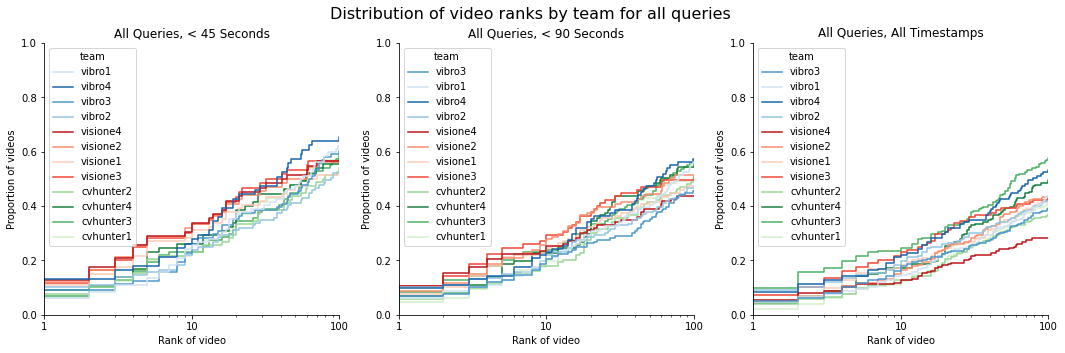

In [34]:
# Define the color palette
palette = {
    'cvhunter': sns.color_palette('Greens', 4),
    'vibro': sns.color_palette('Blues', 4),
    'visione': sns.color_palette('Reds', 4)
}

# Create a dictionary to map team names to colors
pl = {}
for i in range(1, 5):
    n = f"cvhunter{i}"
    pl[n] = palette["cvhunter"][i-1]

for i in range(1, 5):
    n = f"vibro{i}"
    pl[n] = palette["vibro"][i-1]

for i in range(1, 5):
    n = f"visione{i}"
    pl[n] = palette["visione"][i-1]

# Create the plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))


i=0
data = dataset[(dataset["elapsed_since_task_start_ms"] < 45*1000)].copy()
sns.ecdfplot(data=data.replace(np.inf, 20000), x="rank_video", hue="team", palette=pl, ax=axs[i])
axs[i].set_xscale("log")
axs[i].set_xlim([1, 100])
axs[i].set_xlabel("Rank of video")
axs[i].set_ylabel("Proportion of videos")
axs[i].set_xticks([1, 10, 100])
axs[i].set_xticklabels(["1", "10", "100"])
axs[i].set_title(f"All Queries, < 45 Seconds")
sns.despine(ax=axs[i])

i=1
data = dataset[(dataset["elapsed_since_task_start_ms"] < 90*1000)].copy()
sns.ecdfplot(data=data.replace(np.inf, 20000), x="rank_video", hue="team", palette=pl, ax=axs[i])
axs[i].set_xscale("log")
axs[i].set_xlim([1, 100])
axs[i].set_xlabel("Rank of video")
axs[i].set_ylabel("Proportion of videos")
axs[i].set_xticks([1, 10, 100])
axs[i].set_xticklabels(["1", "10", "100"])
axs[i].set_title(f"All Queries, < 90 Seconds")
sns.despine(ax=axs[i])

i=2
data = dataset.copy()
sns.ecdfplot(data=data.replace(np.inf, 20000), x="rank_video", hue="team", palette=pl, ax=axs[i])
axs[i].set_xscale("log")
axs[i].set_xlim([1, 100])
axs[i].set_xlabel("Rank of video")
axs[i].set_ylabel("Proportion of videos")
axs[i].set_xticks([1, 10, 100])
axs[i].set_xticklabels(["1", "10", "100"])
axs[i].set_title(f"All Queries, All Timestamps")
sns.despine(ax=axs[i])


# Set the title and adjust the font size
fig.suptitle("Distribution of video ranks by team for all queries", fontsize=16)


# Display the plot
plt.show()
fig.savefig('./plots/cum_video_rank_distribution.pdf', dpi=200, pad_inches=0.1, bbox_inches='tight')

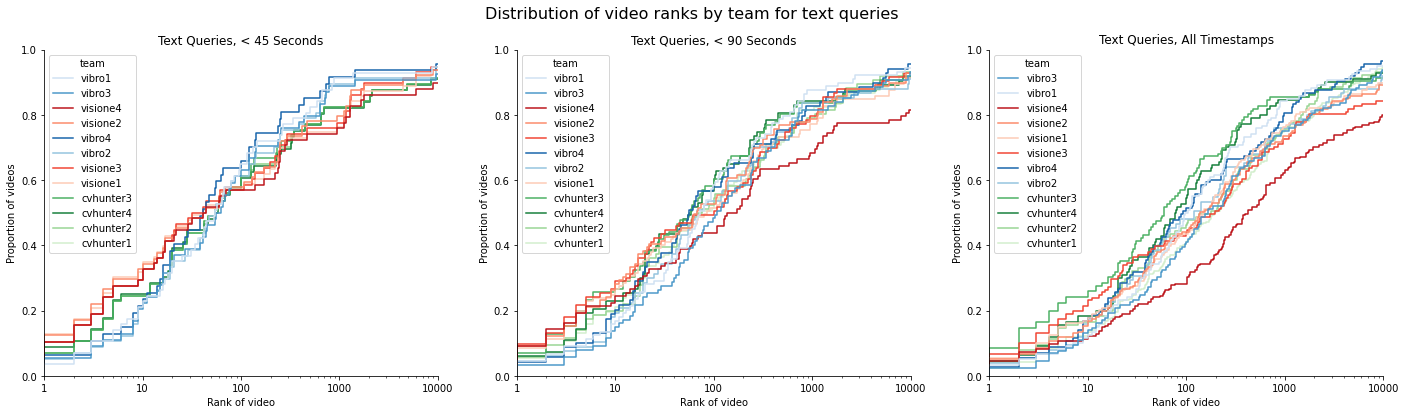

In [35]:
# Define the color palette
palette = {
    'cvhunter': sns.color_palette('Greens', 4),
    'vibro': sns.color_palette('Blues', 4),
    'visione': sns.color_palette('Reds', 4)
}

# Create a dictionary to map team names to colors
pl = {}
for i in range(1, 5):
    n = f"cvhunter{i}"
    pl[n] = palette["cvhunter"][i-1]

for i in range(1, 5):
    n = f"vibro{i}"
    pl[n] = palette["vibro"][i-1]

for i in range(1, 5):
    n = f"visione{i}"
    pl[n] = palette["visione"][i-1]

# Create the plot
fig, axs = plt.subplots(1, 3, figsize=(24, 6))


i=0
data = dataset[(dataset['category'] == 'TEXT') & (dataset["elapsed_since_task_start_ms"] < 45*1000)].copy()
sns.ecdfplot(data=data.replace(np.inf, 20000), x="rank_video", hue="team", palette=pl, ax=axs[i])
axs[i].set_xscale("log")
axs[i].set_xlim([1, 10000])
axs[i].set_xlabel("Rank of video")
axs[i].set_ylabel("Proportion of videos")
axs[i].set_xticks([1, 10, 100, 1000, 10000])
axs[i].set_xticklabels(["1", "10", "100", "1000", "10000"])
axs[i].set_title(f"Text Queries, < 45 Seconds")
sns.despine(ax=axs[i])

i=1
data = dataset[(dataset['category'] == 'TEXT') & (dataset["elapsed_since_task_start_ms"] < 90*1000)].copy()
sns.ecdfplot(data=data.replace(np.inf, 20000), x="rank_video", hue="team", palette=pl, ax=axs[i])
axs[i].set_xscale("log")
axs[i].set_xlim([1, 10000])
axs[i].set_xlabel("Rank of video")
axs[i].set_ylabel("Proportion of videos")
axs[i].set_xticks([1, 10, 100, 1000, 10000])
axs[i].set_xticklabels(["1", "10", "100", "1000", "10000"])
axs[i].set_title(f"Text Queries, < 90 Seconds")
sns.despine(ax=axs[i])

i=2
data = dataset[dataset['category'] == 'TEXT'].copy()
sns.ecdfplot(data=data.replace(np.inf, 20000), x="rank_video", hue="team", palette=pl, ax=axs[i])
axs[i].set_xscale("log")
axs[i].set_xlim([1, 10000])
axs[i].set_xlabel("Rank of video")
axs[i].set_ylabel("Proportion of videos")
axs[i].set_xticks([1, 10, 100, 1000, 10000])
axs[i].set_xticklabels(["1", "10", "100", "1000", "10000"])
axs[i].set_title(f"Text Queries, All Timestamps")
sns.despine(ax=axs[i])


# Set the title and adjust the font size
fig.suptitle("Distribution of video ranks by team for text queries", fontsize=16)


# Display the plot
plt.show()


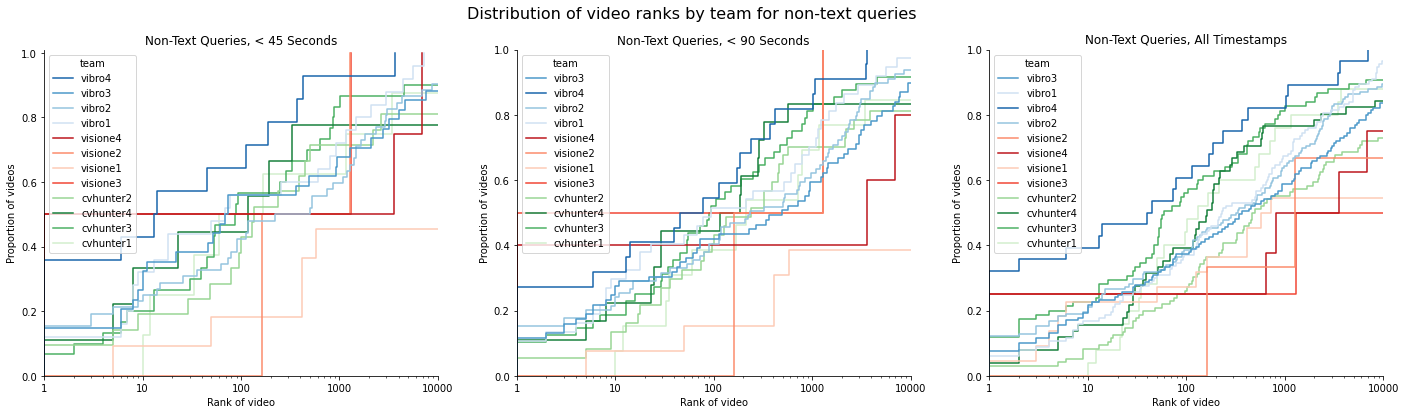

In [36]:
# Define the color palette
palette = {
    'cvhunter': sns.color_palette('Greens', 4),
    'vibro': sns.color_palette('Blues', 4),
    'visione': sns.color_palette('Reds', 4)
}

# Create a dictionary to map team names to colors
pl = {}
for i in range(1, 5):
    n = f"cvhunter{i}"
    pl[n] = palette["cvhunter"][i-1]

for i in range(1, 5):
    n = f"vibro{i}"
    pl[n] = palette["vibro"][i-1]

for i in range(1, 5):
    n = f"visione{i}"
    pl[n] = palette["visione"][i-1]

# Create the plot
fig, axs = plt.subplots(1, 3, figsize=(24, 6))


i=0
data = dataset[(dataset['category'] != 'TEXT') & (dataset["elapsed_since_task_start_ms"] < 45*1000)].copy()
sns.ecdfplot(data=data.replace(np.inf, 20000), x="rank_video", hue="team", palette=pl, ax=axs[i])
axs[i].set_xscale("log")
axs[i].set_xlim([1, 10000])
axs[i].set_ylim([0, 1.01])
axs[i].set_xlabel("Rank of video")
axs[i].set_ylabel("Proportion of videos")
axs[i].set_xticks([1, 10, 100, 1000, 10000])
axs[i].set_xticklabels(["1", "10", "100", "1000", "10000"])
axs[i].set_title(f"Non-Text Queries, < 45 Seconds")
sns.despine(ax=axs[i])

i=1
data = dataset[(dataset['category'] != 'TEXT') & (dataset["elapsed_since_task_start_ms"] < 90*1000)].copy()
sns.ecdfplot(data=data.replace(np.inf, 20000), x="rank_video", hue="team", palette=pl, ax=axs[i])
axs[i].set_xscale("log")
axs[i].set_xlim([1, 10000])
axs[i].set_xlabel("Rank of video")
axs[i].set_ylabel("Proportion of videos")
axs[i].set_xticks([1, 10, 100, 1000, 10000])
axs[i].set_xticklabels(["1", "10", "100", "1000", "10000"])
axs[i].set_title(f"Non-Text Queries, < 90 Seconds")
sns.despine(ax=axs[i])

i=2
data = dataset[dataset['category'] != 'TEXT'].copy()
sns.ecdfplot(data=data.replace(np.inf, 20000), x="rank_video", hue="team", palette=pl, ax=axs[i])
axs[i].set_xscale("log")
axs[i].set_xlim([1, 10000])
axs[i].set_xlabel("Rank of video")
axs[i].set_ylabel("Proportion of videos")
axs[i].set_xticks([1, 10, 100, 1000, 10000])
axs[i].set_xticklabels(["1", "10", "100", "1000", "10000"])
axs[i].set_title(f"Non-Text Queries, All Timestamps")
sns.despine(ax=axs[i])


# Set the title and adjust the font size
fig.suptitle("Distribution of video ranks by team for non-text queries", fontsize=16)


# Display the plot
plt.show()


In [37]:
from scipy.interpolate import interp1d
common_timestamps = np.linspace(0, 300000, num=300000)
def create_time_plot(team, dataset, empty_val=0, column="rank_video"): #rank_shot_margin_5
    
    team_data = dataset[dataset["team"] == team].sort_values(by='timestamp', ascending=True).replace(np.inf, 10000)#.groupby(["task"]).apply(lambda x: x.interpolate())#.reset_index()
    
    #print(team)
    #display(team_data.head())
    task_data_list = []
#     min_timestamp = np.inf
#     max_timestamp = -np.inf
    for task in dataset["task"].unique():
        task_data = team_data[team_data["task"] == task]
        #print(task, task_data[["elapsed_since_task_start_ms", "rank_video"]])
        task_data_list.append(task_data[["elapsed_since_task_start_ms", column]].values)
        
#         ct_min = np.min(task_data_list[-1][:, 0])
#         ct_max = np.max(task_data_list[-1][:, 0])
        
#         if ct_min < min_timestamp: min_timestamp = ct_min
#         if ct_max > max_timestamp: max_timestamp = ct_max
        
    
    
    #print(common_timestamps)
    
    average_vals = np.zeros_like(common_timestamps)
    
    len_adjuster = 0
    value_list = []
    for data in task_data_list:
        
        if len(data) == 0:
            len_adjuster += 1
            continue
        if len(data) > 1:
            #print(1/data)
            f1 = interp1d(data[:, 0], 1/data[:, 1], kind='nearest', fill_value=0, bounds_error=False)
            interpolated_values = f1(common_timestamps)
            #interpolated_values = np.interp1d(x=)
            #print(interpolated_values[:100])
            indices = np.nonzero(interpolated_values)[0]
           
            first_nonzero_index = indices[0] if len(indices) > 0 else 0
            last_nonzero_index = indices[-1] if len(indices) > 0 else 0
            interpolated_values[:first_nonzero_index] = empty_val
            interpolated_values[last_nonzero_index:] = 1/data[-1, 1]
           
        else:
            interpolated_values = 1/np.ones_like(common_timestamps) * empty_val
            interpolated_values[int(data[0, 0]):] = 1/data[0,1]
            
        value_list.append(interpolated_values)
        
        average_vals = average_vals + interpolated_values
        
    average_vals = average_vals / (len(task_data_list)-len_adjuster)
    #average_vals = np.median(value_list, axis=0)
    
    return average_vals
    

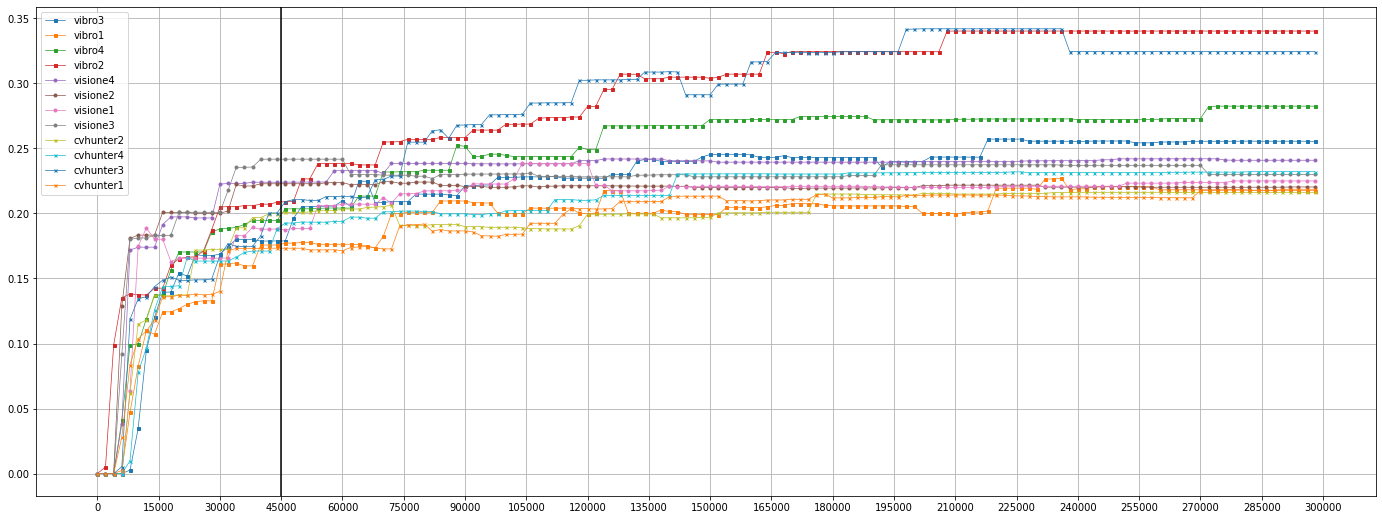

In [38]:
plt.figure(figsize=(24, 9))

for team in dataset["team"].unique():
    if "vibro" in team:
        plt.plot(common_timestamps[::2000], create_time_plot(team, dataset)[::2000], "-s", label=team, linewidth=0.7, markersize=3)
    if "cv" in team:
        plt.plot(common_timestamps[::2000], create_time_plot(team, dataset)[::2000], "-x", label=team, linewidth=0.7, markersize=3)
    if "visione" in team:
        plt.plot(common_timestamps[::2000], create_time_plot(team, dataset)[::2000], "-o", label=team, linewidth=0.7, markersize=3)

# Set xticks at every 1000s
xticks = np.arange(0, max(common_timestamps)+1, 15000)
plt.xticks(xticks)

plt.legend()
plt.axvline(x=45000, color='black')
plt.grid()
plt.show()


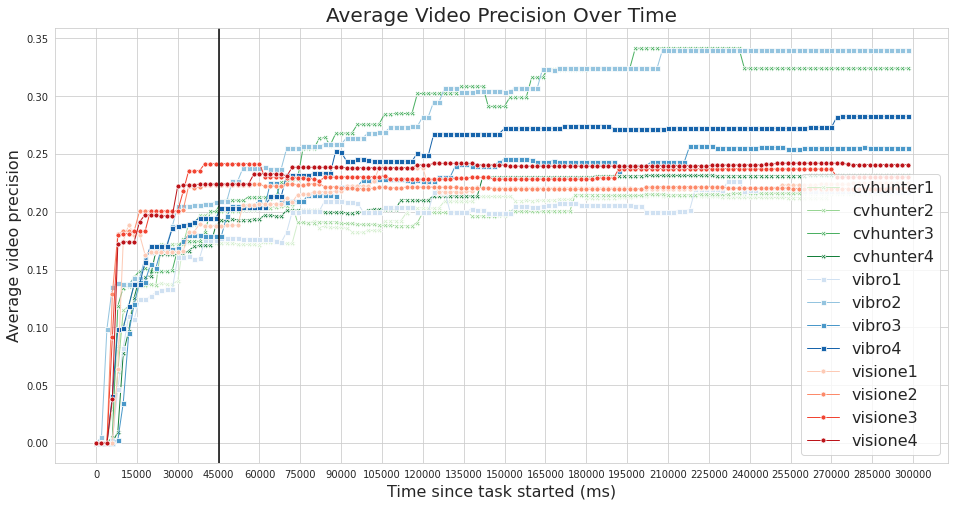

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = {
    'cvhunter': sns.color_palette('Greens', 4),
    'vibro': sns.color_palette('Blues', 4),
    'visione': sns.color_palette('Reds', 4)
}

# Set style
sns.set_style("whitegrid")

# Create figure
fig, ax = plt.subplots(figsize=(16,8))

# Iterate over teams
vic, cvc, visc = 0, 0, 0
for i, team in enumerate(sorted(dataset["team"].unique())):
    if "vibro" in team:
        sns.lineplot(x=common_timestamps[::2000], y=create_time_plot(team, dataset)[::2000], 
                     ax=ax, label=team, linewidth=1, markersize=5, marker="s", color=palette["vibro"][vic])
        vic += 1
    if "cv" in team:
        sns.lineplot(x=common_timestamps[::2000], y=create_time_plot(team, dataset)[::2000], 
                     ax=ax, label=team, linewidth=1, markersize=5, marker="X", color=palette["cvhunter"][cvc])
        cvc+=1
    if "visione" in team:
        sns.lineplot(x=common_timestamps[::2000], y=create_time_plot(team, dataset)[::2000], 
                     ax=ax, label=team, linewidth=1, markersize=5, marker="o", color=palette["visione"][visc])
        visc+=1

# Set xticks at every 15000s
xticks = np.arange(0, max(common_timestamps)+1, 15000)
ax.set_xticks(xticks)

# Add title and legend
ax.set_title("Average Video Precision Over Time", fontsize=20)
ax.legend(fontsize=16)

# Set axis labels
ax.set_xlabel("Time since task started (ms)", fontsize=16)
ax.set_ylabel("Average video precision", fontsize=16)
#ax.set_ylim([0, 110])
plt.axvline(x=45000, color='black')
# Show plot
plt.show()
fig.savefig('./plots/video_precision_over_time_all_queries.pdf', dpi=160, pad_inches=0.1, bbox_inches='tight')

In [40]:
text_only_dataset = dataset[dataset['QT'] == 'Text']
non_text_dataset = dataset[dataset['QT'] != 'Text']

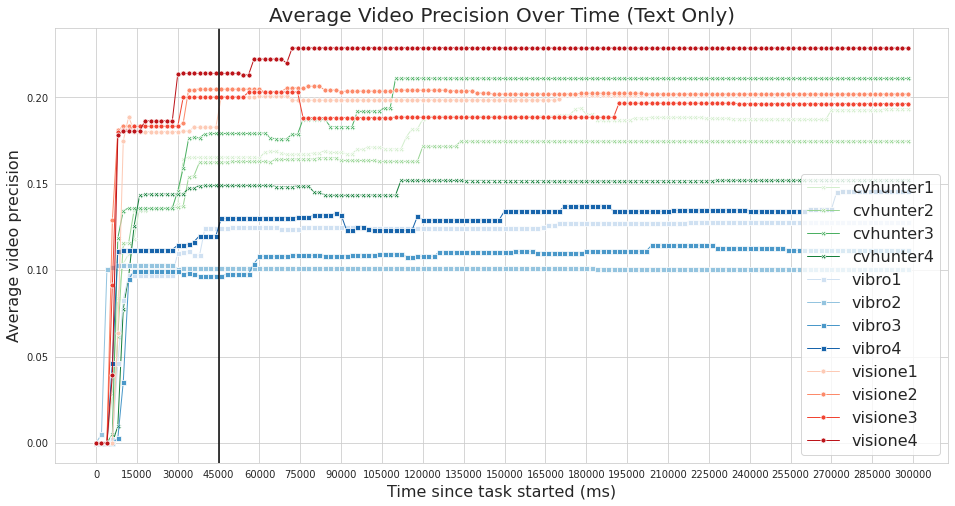

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = {
    'cvhunter': sns.color_palette('Greens', 4),
    'vibro': sns.color_palette('Blues', 4),
    'visione': sns.color_palette('Reds', 4)
}

# Set style
sns.set_style("whitegrid")

# Create figure
fig, ax = plt.subplots(figsize=(16,8))

# Iterate over teams
vic, cvc, visc = 0, 0, 0
for i, team in enumerate(sorted(dataset["team"].unique())):
    if "vibro" in team:
        sns.lineplot(x=common_timestamps[::2000], y=create_time_plot(team, text_only_dataset)[::2000], 
                     ax=ax, label=team, linewidth=1, markersize=5, marker="s", color=palette["vibro"][vic])
        vic += 1
    if "cv" in team:
        sns.lineplot(x=common_timestamps[::2000], y=create_time_plot(team, text_only_dataset)[::2000], 
                     ax=ax, label=team, linewidth=1, markersize=5, marker="X", color=palette["cvhunter"][cvc])
        cvc+=1
    if "visione" in team:
        sns.lineplot(x=common_timestamps[::2000], y=create_time_plot(team, text_only_dataset)[::2000], 
                     ax=ax, label=team, linewidth=1, markersize=5, marker="o", color=palette["visione"][visc])
        visc+=1

# Set xticks at every 15000s
xticks = np.arange(0, max(common_timestamps)+1, 15000)
ax.set_xticks(xticks)

# Add title and legend
ax.set_title("Average Video Precision Over Time (Text Only)", fontsize=20)
ax.legend(fontsize=16)

# Set axis labels
ax.set_xlabel("Time since task started (ms)", fontsize=16)
ax.set_ylabel("Average video precision", fontsize=16)
#ax.set_ylim([0, 110])
plt.axvline(x=45000, color='black')
# Show plot
plt.show()
fig.savefig('./plots/video_precision_over_time_text_queries.pdf', dpi=160, pad_inches=0.1, bbox_inches='tight')

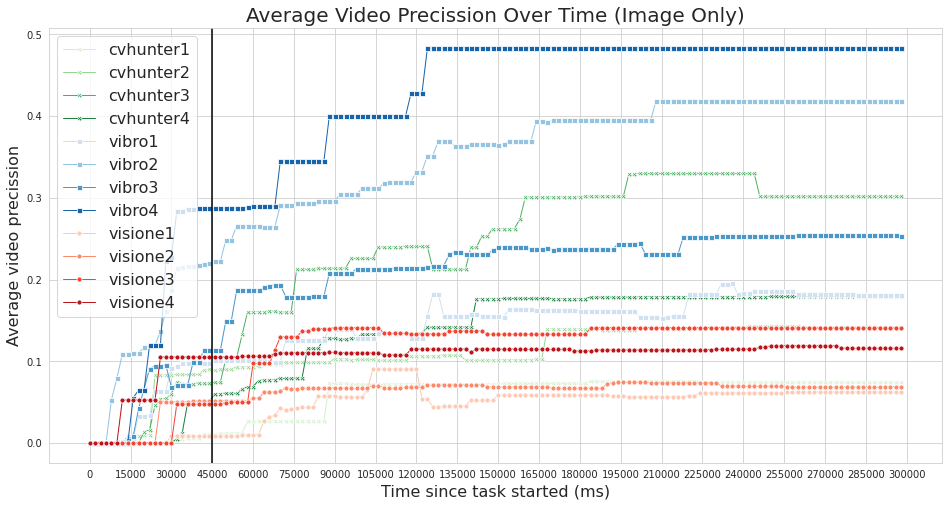

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = {
    'cvhunter': sns.color_palette('Greens', 4),
    'vibro': sns.color_palette('Blues', 4),
    'visione': sns.color_palette('Reds', 4)
}

# Set style
sns.set_style("whitegrid")

# Create figure
fig, ax = plt.subplots(figsize=(16,8))

# Iterate over teams
vic, cvc, visc = 0, 0, 0
for i, team in enumerate(sorted(dataset["team"].unique())):
    if "vibro" in team:
        sns.lineplot(x=common_timestamps[::2000], y=create_time_plot(team, non_text_dataset)[::2000], 
                     ax=ax, label=team, linewidth=1, markersize=5, marker="s", color=palette["vibro"][vic])
        vic += 1
    if "cv" in team:
        sns.lineplot(x=common_timestamps[::2000], y=create_time_plot(team, non_text_dataset)[::2000], 
                     ax=ax, label=team, linewidth=1, markersize=5, marker="X", color=palette["cvhunter"][cvc])
        cvc+=1
    if "visione" in team:
        sns.lineplot(x=common_timestamps[::2000], y=create_time_plot(team, non_text_dataset)[::2000], 
                     ax=ax, label=team, linewidth=1, markersize=5, marker="o", color=palette["visione"][visc])
        visc+=1

# Set xticks at every 15000s
xticks = np.arange(0, max(common_timestamps)+1, 15000)
ax.set_xticks(xticks)

# Add title and legend
ax.set_title("Average Video Precission Over Time (Image Only)", fontsize=20)
ax.legend(fontsize=16)

# Set axis labels
ax.set_xlabel("Time since task started (ms)", fontsize=16)
ax.set_ylabel("Average video precission", fontsize=16)
#ax.set_ylim([0, 110])
plt.axvline(x=45000, color='black')
# Show plot
plt.show()

fig.savefig('./plots/video_precision_over_time_image_queries.pdf', dpi=160, pad_inches=0.1, bbox_inches='tight')

In [43]:
ds["precision_video"] = 1/ds["rank_video"]

In [44]:
ds.groupby(["System", "QT"])[["precision_video"]].mean()

precision_video
System   QT                       
cvhunter IMAGE            0.088143
         TEMPORAL         0.081728
         Text             0.096075
vibro    Color            0.004296
         IMAGE            0.159446
         TEMPORAL         0.073488
         Text             0.068480
visione  IMAGE            0.135237
         ODLS             0.007676
         TEMPORAL         0.038142
         Text             0.138714

In [45]:
ds2 = ds[ds["QT"].isin(["IMAGE", "Text", "TEMPORAL"])]
ds2.groupby(["System", "QT", pd.cut(ds2["elapsed_since_task_start_ms"], [0, 45*1000, 90*1000, 5*60*1000])])[["precision_video"]].mean()

precision_video
System   QT       elapsed_since_task_start_ms                 
cvhunter IMAGE    (0, 45000]                          0.109597
                  (45000, 90000]                      0.099235
                  (90000, 300000]                     0.072943
         TEMPORAL (0, 45000]                               NaN
                  (45000, 90000]                      0.117686
                  (90000, 300000]                     0.058980
         Text     (0, 45000]                          0.138595
                  (45000, 90000]                      0.078777
                  (90000, 300000]                     0.047944
vibro    IMAGE    (0, 45000]                          0.208918
                  (45000, 90000]                      0.170603
                  (90000, 300000]                     0.108782
         TEMPORAL (0, 45000]                          0.004934
                  (45000, 90000]                      0.092185
                  (90000, 300000]                     0.072921
         Text     (0, 45000]                          0.103038
                  (45000, 90000]                      0.041868
                  (90000, 300000]                     0.029690
visione  IMAGE    (0, 45000]                          0.170264
                  (45000, 90000]                      0.000050
                  (90000, 300000]                     0.117905
         TEMPORAL (0, 45000]                          1.000000
                  (45000, 90000]                      0.072606
                  (90000, 300000]                     0.015096
         Text     (0, 45000]                          0.191651
                  (45000, 90000]                      0.124809
                  (90000, 300000]                     0.017409